In [1]:
!nvidia-smi

Tue May 30 11:35:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 45%   32C    P8    N/A /  75W |   1197MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import Libary
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from matplotlib.ticker import MaxNLocator

import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from wordcloud import WordCloud

import gensim
from gensim import models
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases, CoherenceModel
import gensim.corpora as corpora

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Load Dataset

In [3]:
# Load Dataset
df = pd.read_csv("../dataset/dataset_preprocess.csv")

In [15]:
# Show first 5 rows
df.head()

,id,text_preprocess,len_char,len_word,tokens,len_token
0,47d0cdd937754bd6b860f89b2bab1dbb,akses jalannya waktu itu masih sulit di jangka...,84,13,"[akses, jalannya, waktu, itu, masih, sulit, ja...",12
1,4804acd6c05e4f89b098e2ca35019419,perjalanan yg bnr bikin syahduu dr tempat park...,110,19,"[perjalanan, bnr, bikin, syahduu, tempat, park...",15
2,61037dbdb7b14045be49d4494e95cf05,mei touring bari mudik mntap perjalanan sungg...,162,25,"[mei, touring, bari, mudik, mntap, perjalanan,...",20
3,a2c9e817e2b949c6880f971f43a11d2f,perjalanan touring motor dari bekasi melewati ...,152,23,"[perjalanan, touring, motor, dari, bekasi, mel...",22
4,772bd029c2ce450b94b6fc6f524fbc05,nyampe lnjut kebawah jam mantap suasana safar,46,8,"[nyampe, lnjut, kebawah, jam, mantap, suasana,...",7


In [14]:
df['tokens'] = df['tokens'].apply(lambda x: eval(x))

# Preprocessing

## Stopwords

In [ ]:
# ''' Stopword by Sastrawi '''

# stop_words = StopWordRemoverFactory().get_stop_words()
# extend_stopword = [
#     'pas', 'yg', 'tp', 'rb', 'km', 'tp', 'dg', 'dr',
#     'bagu','bagus','bagusnya',
#     'banyaknya','banyakny','banyak',
#     'jlan','jalan',
#     'masuk','tempat',
#     'atas','sana','karna','sama','saya','sudah','udah','mungkin', 'tuji','jadi','saja','sini','kalo','kalau',
#     'untuk','semua','buat','bisa','cuma','sangat','buat','unutk','paling','cukup','naik','ribu','sekali',
#     'benar','kesini','turun','sera','sayangny','anjur','mending','dapat', 'punya','mana','sekitar',
#     'dapet','coba','bukan','sebut','sampe','tuju','hingga','beberapa','banget',
#     'utk','gak','adl','dll','coba','klo','nya','pas','per','bnr','udh','lua','aja','bgt','lalu','krn','mau',
# ]

# stop_words += extend_stopword

In [ ]:
''' Stopword by NLTK '''

stop_words = stopwords.words('indonesian')
# stop_words = sorted(list(set(stopwords.words('indonesian')) - set(['jauh'])))
# stop_words.extend([
#     'pas', 'yg', 'tp', 'rb', 'km', 'tp', 'dg', 'dr', 'nya',
#     'bagu','bagus','bagusnya',
#     'banyaknya','banyakny','banyak',
#     'jlan','jalan',
#     'masuk','tempat',
#     'atas','sana','karna','sama','saya','sudah','udah','mungkin', 'tuji','jadi','saja','sini','kalo','kalau',
#     'untuk','semua','buat','bisa','cuma','sangat','buat','unutk','paling','cukup','naik','ribu','sekali',
#     'benar','kesini','turun','sera','sayangny','anjur','mending','dapat', 'punya','mana','sekitar',
#     'dapet','coba','bukan','sebut','sampe','tuju','hingga','beberapa','banget',
#     'utk','gak','adl','dll','coba','klo','nya','pas','per','bnr','udh','lua','aja','bgt','lalu','krn','mau',
# ])

In [ ]:
df['tokens'] = df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

## Stemming

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
df['tokens'] = df['tokens'].apply(lambda x: stemmer.stem(' '.join(x)).split(' '))

# Data Transformation

## Bigram & Trigram Models

In [6]:
# bigram = Phrases(texts, min_count=10)
# trigram = Phrases(bigram[texts])

# for idx in range(len(texts)):
#     for token in bigram[texts[idx]]:
#         if '_' in token:
#             texts[idx].append(token)
#     for token in trigram[texts[idx]]:
#         if '_' in token:
#             texts[idx].append(token)

## Create corpus

In [7]:
# Initiate Corpus
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=5, no_above=0.2)

# texts = df['tokens']
# corpus = [id2word.doc2bow(text) for text in texts]

In [8]:
# BoW Corpus
corpus = [id2word.doc2bow(text) for text in texts]

In [9]:
# id2word = corpora.Dictionary(df['tokens'])
# texts = df['tokens']
# corpus = [id2word.doc2bow(text) for text in texts]

In [10]:
# TF-IDF Corpus
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Apply Model

In [22]:
def compute_coherence_values(id2word, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel( #LdaModel gensim.models.LdaMulticore
                    corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, iterations=100,
                    # chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, 
                    # decay=0.5, offset=1.0, eval_every=10, gamma_threshold=0.001
                    )
        
        model_list.append(model)
        coherence_model = CoherenceModel(
                            model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

In [23]:
START = 1
LIMIT = 11
STEP = 1

model_list, coherence_values = compute_coherence_values(
    id2word=id2word, corpus=corpus, texts=texts, start=START, limit=LIMIT, step=STEP)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.79s/it]


# Evaluate

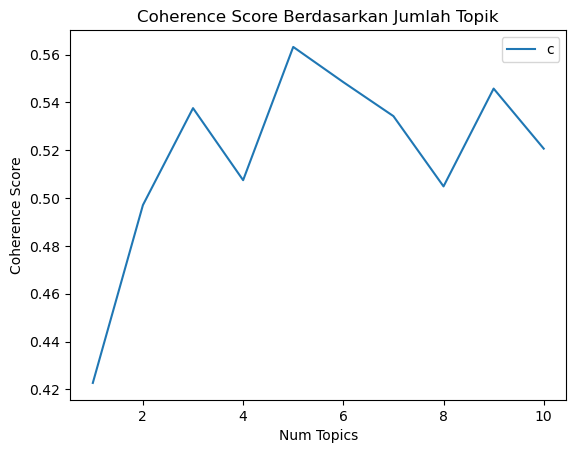

In [24]:
x = range(START, LIMIT, STEP)
plt.plot(x, coherence_values)
plt.title('Coherence Score Berdasarkan Jumlah Topik')
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
# plt.xticks(range(min(x), max(x)+1))
# plt.xlim(1, LIMIT-1)
# plt.xticks(coherence_values, x)
plt.legend(('coherence_values'), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    # print(f'{cv:.3f}')
    print(f'Num topics = {m}, has Coherence Score of {cv:.3f}')

Num topics = 1, has Coherence Score of 0.423
Num topics = 2, has Coherence Score of 0.497
Num topics = 3, has Coherence Score of 0.538
Num topics = 4, has Coherence Score of 0.507
Num topics = 5, has Coherence Score of 0.563
Num topics = 6, has Coherence Score of 0.548
Num topics = 7, has Coherence Score of 0.534
Num topics = 8, has Coherence Score of 0.505
Num topics = 9, has Coherence Score of 0.546
Num topics = 10, has Coherence Score of 0.521


In [30]:
model = model_list[4]

In [31]:
x = model.show_topics(num_topics=5, formatted=False)
# coherence_ldas = model.get_coherence_per_topic()
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

In [32]:
# # Below Code Prints Topics and Words
# for each_topic_coherence_score in enumerate(coherence_ldas):
#     print(f'Topic {each_topic_coherence_score[0]}: {each_topic_coherence_score[1]:.5f}')

In [33]:
# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(f'Topic {topic}: {words}')

Topic 0: ['foto', 'sejuk', 'tempat', 'nyaman', 'spot', 'keluarga', 'cocok', 'acara', 'suka', 'suasana']
Topic 1: ['wisata', 'foto', 'jalan', 'tangkuban', 'air', 'lokasi', 'bandung', 'gunung', 'tempat', 'tiket']
Topic 2: ['tiket', 'bayar', 'wisata', 'parkir', 'kawah', 'makan', 'harga', 'foto', 'spot', 'floating']
Topic 3: ['anak', 'makan', 'main', 'keluarga', 'cocok', 'wisata', 'sejuk', 'luas', 'tempat', 'bersih']
Topic 4: ['alam', 'hutan', 'dingin', 'indah', 'pandang', 'wisata', 'pinus', 'hujan', 'alami', 'suasana']


In [34]:
# Below Code Prints Topics and Words with probability
for idx, topic in model.print_topics(-1):
    print(f'Topic: {idx}, Word: {topic}')

Topic: 0, Word: 0.031*"foto" + 0.028*"sejuk" + 0.026*"tempat" + 0.024*"nyaman" + 0.021*"spot" + 0.019*"keluarga" + 0.016*"cocok" + 0.013*"acara" + 0.013*"suka" + 0.010*"suasana"
Topic: 1, Word: 0.019*"wisata" + 0.014*"foto" + 0.013*"jalan" + 0.013*"tangkuban" + 0.013*"air" + 0.012*"lokasi" + 0.012*"bandung" + 0.011*"gunung" + 0.011*"tempat" + 0.011*"tiket"
Topic: 2, Word: 0.022*"tiket" + 0.021*"bayar" + 0.021*"wisata" + 0.020*"parkir" + 0.017*"kawah" + 0.017*"makan" + 0.016*"harga" + 0.016*"foto" + 0.013*"spot" + 0.008*"floating"
Topic: 3, Word: 0.021*"anak" + 0.021*"makan" + 0.018*"main" + 0.017*"keluarga" + 0.016*"cocok" + 0.015*"wisata" + 0.015*"sejuk" + 0.015*"luas" + 0.014*"tempat" + 0.013*"bersih"
Topic: 4, Word: 0.024*"alam" + 0.018*"hutan" + 0.017*"dingin" + 0.016*"indah" + 0.015*"pandang" + 0.011*"wisata" + 0.011*"pinus" + 0.010*"hujan" + 0.010*"alami" + 0.010*"suasana"


In [42]:
model[corpus][200]

[(0, 0.12987693), (1, 0.85251313)]

In [48]:
import matplotlib.colors as mcolors

# Get topic weights
# topic_weights = []
# for i, row_list in enumerate(model[corpus]):
#     topic_weights.append([w for i, w in row_list[0]])
topic_weights = np.zeros((len(corpus), 5))
for i, vektor_topik_dokumen in enumerate(model[corpus]):
    for topik, probabilitas in vektor_topik_dokumen:
        topic_weights[i, topik] = probabilitas

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

C:\Users\Fakhri\anaconda3\envs\aidev\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10867 samples in 0.012s...
[t-SNE] Computed neighbors for 10867 samples in 0.233s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10867
[t-SNE] Computed conditional probabilities for sample 2000 / 10867
[t-SNE] Computed conditional probabilities for sample 3000 / 10867
[t-SNE] Computed conditional probabilities for sample 4000 / 10867
[t-SNE] Computed conditional probabilities for sample 5000 / 10867
[t-SNE] Computed conditional probabilities for sample 6000 / 10867
[t-SNE] Computed conditional probabilities for sample 7000 / 10867
[t-SNE] Computed conditional probabilities for sample 8000 / 10867
[t-SNE] Computed conditional probabilities for sample 9000 / 10867
[t-SNE] Computed conditional probabilities for sample 10000 / 10867
[t-SNE] Computed conditional probabilities for sample 10867 / 10867
[t-SNE] Mean sigma: 0.001154


C:\Users\Fakhri\anaconda3\envs\aidev\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.719757
[t-SNE] KL divergence after 1000 iterations: 0.778565


Loading BokehJS ...